# Load Libraries and Data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, log_loss, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
bank_df = pd.read_csv('data/bank-additional-full.csv', sep=';')
bank_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# About the Dataset

This dataset is publicly available for research and is based on "Bank Marketing" UCI dataset. The details are described in [Moro et al., 2014]. 

**Input Variables:**

1. age (numeric)
2. job : type of job (categorical: "admin.", "blue-collar", "entrepreneur", "housemaid", "management", "retired", "self-employed", "services", "student", "technician", "unemployed", "unknown"
3. marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
4. education (categorical: "basic.4y", "basic.6y", "basic.9y", "high.school", "illiterate", "professional.course", "university.degree","unknown")
5. default: has credit in default? (categorical: "no", "yes", "unknown")
6. housing: has housing loan? (categorical: "no", "yes", "unknown")
7. loan: has personal loan? (categorical: "no", "yes", "unknown")


    **Related with the last contact of the current campaign:**
8. contact: contact communication type (categorical: "cellular", "telephone") 
9. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
10. day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
11. duration: last contact duration, in seconds (numeric). **Important note:**  This attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.


    **Other attributes:**
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: "failure", "nonexistent", "success")


    **Social and economic context attributes:**
16. emp.var.rate: employment variation rate - quarterly indicator (numeric)  
17. cons.price.idx: consumer price index - monthly indicator (numeric)
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)


**Output variable (desired target):**
21. y - has the client subscribed a term deposit? (binary: "yes","no")

# Exploring the Data

In [3]:
bank_df.shape

(41188, 21)

In [4]:
bank_df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [12]:
bank_df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [5]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [6]:
bank_df.nunique()

age                 78
job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1544
campaign            42
pdays               27
previous             8
poutcome             3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          316
nr.employed         11
y                    2
dtype: int64

In [7]:
bank_df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [8]:
bank_df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [14]:
num_unknown = (bank_df[bank_df.columns] == 'unknown').sum()
print(num_unknown)

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64


In [15]:
bank_df['job'].value_counts()

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

In [17]:
bank_df['marital'].value_counts()

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

In [19]:
bank_df['education'].value_counts()

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

In [20]:
bank_df['default'].value_counts()

no         32588
unknown     8597
yes            3
Name: default, dtype: int64

In [21]:
bank_df['housing'].value_counts()

yes        21576
no         18622
unknown      990
Name: housing, dtype: int64

In [26]:
bank_df['poutcome'].value_counts()

nonexistent    35563
failure         4252
success         1373
Name: poutcome, dtype: int64

In [27]:
bank_df['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

# Data Cleaning

In [39]:
#Checking for duplicates
bank_df[bank_df.duplicated()]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,124,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,88,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,331,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,43,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,128,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
20216,55,services,married,high.school,unknown,no,no,cellular,aug,mon,33,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no
20534,41,technician,married,professional.course,no,yes,no,cellular,aug,tue,127,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no
25217,39,admin.,married,university.degree,no,no,no,cellular,nov,tue,123,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,no
28477,24,services,single,high.school,no,yes,no,cellular,apr,tue,114,1,999,0,nonexistent,-1.8,93.075,-47.1,1.423,5099.1,no
32516,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,348,4,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no


In [6]:
#Removing duplicates
bank_df.drop_duplicates(inplace=True)

In [7]:
#Removing missing values on categorical binary columns (marked as unknown in this dataset)
bank_df.drop(bank_df[bank_df['default'] == 'unknown'].index, inplace = True)

In [8]:
bank_df.drop(bank_df[bank_df['loan'] == 'unknown'].index, inplace = True)

In [9]:
bank_df.shape

(31817, 21)

# Transforming the Data

In [6]:
bank_df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [4]:
#Defining variables
target_variable = ['y'] 
binary_variables = ['default', 'housing', 'loan']
nominal_variables = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
ordinal_variable = ['day_of_week']

In [5]:
continuous_variables = [column for column in bank_df.columns
                        if column not in set(nominal_variables
                                             + ordinal_variable
                                             + binary_variables
                                             + target_variable)]
continuous_variables

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

In [6]:
#Transform target variable
bank_df['y'] = np.where(bank_df['y'] == 'no', 0, 1)
bank_df.rename(columns = {'y':'target'}, inplace=True)

In [7]:
#Create ColumnTransformer
data_transformer = ColumnTransformer(transformers=[
    ('continuous', 'passthrough', continuous_variables),
    ('binary', OrdinalEncoder(), binary_variables),
    ('ordinal', OrdinalEncoder(), ordinal_variable),
    ('nominal', OneHotEncoder(sparse=False), nominal_variables)], 
    remainder='drop')

In [24]:
bank_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,target
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,139,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [8]:
#Set variables
X = bank_df.drop(columns = ['target'])
y = bank_df.target

In [9]:
#Train test split
X_rest, X_test, y_rest, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
#Split rest set into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_rest, 
                                                   y_rest,
                                                  random_state=42,
                                                  test_size=0.25)

In [11]:
#Fit 
data_transformer.fit(X)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('continuous', 'passthrough',
                                 ['age', 'duration', 'campaign', 'pdays',
                                  'previous', 'emp.var.rate', 'cons.price.idx',
                                  'cons.conf.idx', 'euribor3m',
                                  'nr.employed']),
                                ('binary',
                                 OrdinalEncoder(categories='auto',
                                                dtype=<class 'numpy.float64'>),
                                 ['default', 'housing', 'loan']),
                                ('ordinal',
                                 OrdinalEncoder(categories='auto',
                                                dtype=<class 'numpy.float64'>),
                                 ['day_of_week']),
                                ('nominal',
            

In [12]:
#Transform dataframe
X_train_transformed = data_transformer.transform(X_train)
X_val_transformed = data_transformer.transform(X_val)
X_test_transformed = data_transformer.transform(X_test)

In [13]:
nominal_names = data_transformer.named_transformers_['nominal'].categories_

transformed_nominal_columns = []

for column, name_list in zip(nominal_variables, nominal_names):
  for name in name_list:
    transformed_nominal_columns.append('_'.join([column,str(name)]))

In [14]:
#Continuous variables, ordinal variables, nominal variables
transformed_columns = continuous_variables \
                    + binary_variables \
                    + ordinal_variable \
                    + transformed_nominal_columns

In [15]:
#Converting back to dataframe
X_train_transform_df = pd.DataFrame(X_train_transformed, columns=transformed_columns)
X_val_transform_df = pd.DataFrame(X_val_transformed, columns=transformed_columns)
X_test_transform_df = pd.DataFrame(X_test_transformed, columns=transformed_columns)
X_train_transform_df.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,default,housing,loan,day_of_week,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_nonexistent,poutcome_success
0,34.0,153.0,3.0,999.0,0.0,1.4,93.918,-42.7,4.968,5228.1,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,32.0,200.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.860,5191.0,1.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,39.0,44.0,1.0,999.0,0.0,-1.8,92.893,-46.2,1.313,5099.1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,46.0,229.0,1.0,999.0,0.0,1.4,93.444,-36.1,4.964,5228.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,73.0,185.0,1.0,999.0,0.0,-3.4,92.431,-26.9,0.724,5017.5,0.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [16]:
print(X_train_transform_df.shape)
print(X_val_transform_df.shape)
print(X_test_transform_df.shape)

(24712, 53)
(8238, 53)
(8238, 53)


# Plotting Numerical Data

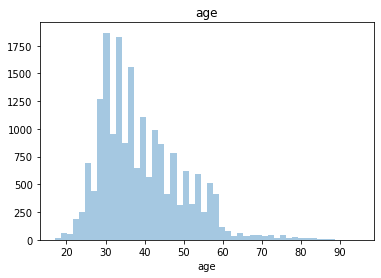

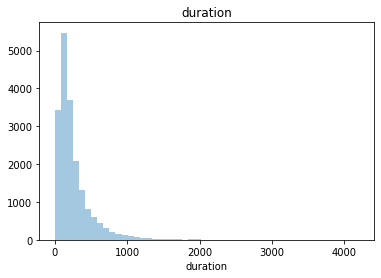

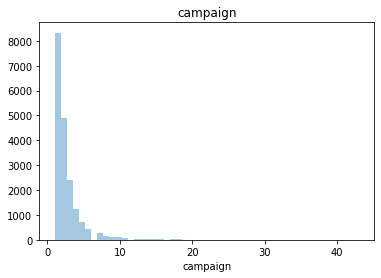

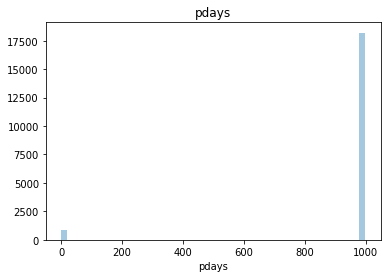

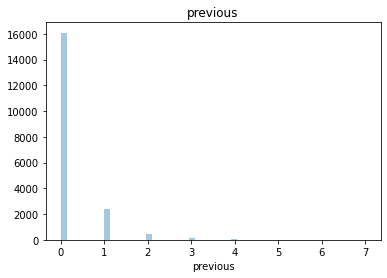

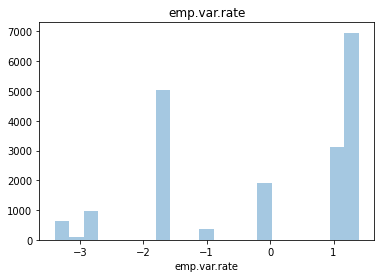

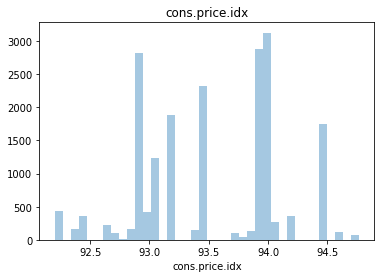

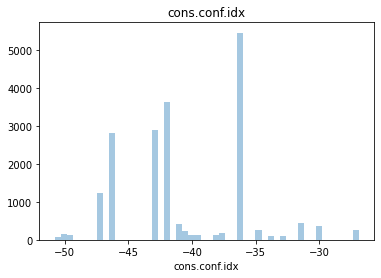

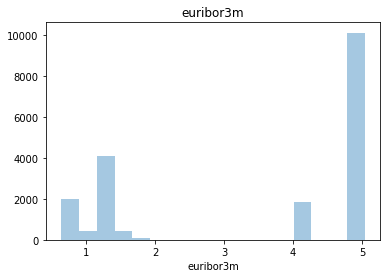

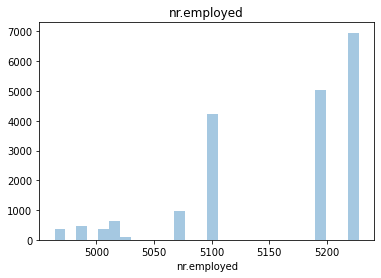

In [26]:
#Plotting numerical data
for column in continuous_variables:
  sns.distplot(X_train_transform_df[column], kde=False)
  plt.title(f'{column}')
  plt.show()

# Feature Selection

## Using Anova for Continuous Independent and Categorical Dependent Variables

In [17]:
#Set continuous variable columns
X_columns = continuous_variables + ordinal_variable

In [18]:
#Scaling the data
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train_transform_df[X_columns])
X_val_scale = scaler.fit_transform(X_val_transform_df[X_columns])
X_test_scale = scaler.fit_transform(X_test_transform_df[X_columns])

In [19]:
X_train_scale

array([[-5.84140141e-01, -4.06032533e-01,  1.50836363e-01, ...,
         7.76256974e-01,  8.44034989e-01,  4.05052966e-04],
       [-7.76583482e-01, -2.25084300e-01, -5.66398235e-01, ...,
         7.13921401e-01,  3.30385496e-01,  4.05052966e-04],
       [-1.03031791e-01, -8.25678434e-01, -5.66398235e-01, ...,
        -1.33334042e+00, -9.41969987e-01, -1.42954765e+00],
       ...,
       [ 2.81854890e-01,  6.45007202e-01, -5.66398235e-01, ...,
        -1.34603841e+00, -9.41969987e-01,  7.15381403e-01],
       [-1.45013517e+00, -5.29231329e-01,  1.50836363e-01, ...,
        -1.36970284e+00, -9.41969987e-01, -1.42954765e+00],
       [-6.80361811e-01, -8.48778208e-01,  8.68070962e-01, ...,
         7.71062343e-01,  8.44034989e-01, -1.42954765e+00]])

In [20]:
#use SelectKBestv
feature_selector_anova = SelectKBest(score_func = f_classif, k=5)
feature_selector_anova.fit(X_train_scale, y_train)

SelectKBest(k=5, score_func=<function f_classif at 0x7fe2e73ee6a8>)

In [21]:
#Anova values
feature_selector_anova.scores_

array([  18.36480215, 4752.00480777,  126.30587711, 2896.53679672,
       1367.06432969, 2430.24762873,  471.60929648,   86.96967637,
       2587.79392407, 3568.69118279,    8.734197  ])

In [22]:
#Getting pvalues
feature_selector_anova.pvalues_

array([1.83086276e-005, 0.00000000e+000, 3.10344874e-029, 0.00000000e+000,
       2.58207135e-291, 0.00000000e+000, 1.33257254e-103, 1.19148542e-020,
       0.00000000e+000, 0.00000000e+000, 3.12591545e-003])

In [23]:
#Selecting features
X_train_transform_df[X_columns].columns[feature_selector_anova.get_support(True)]

Index(['duration', 'pdays', 'emp.var.rate', 'euribor3m', 'nr.employed'], dtype='object')

## Using Chi-square for Categorical Independent and Dependent Variables

In [24]:
feature_selector_chi2 = SelectKBest(score_func = chi2, k=6)
feature_selector_chi2.fit(X_train_transform_df.drop(columns=X_columns), y_train)

SelectKBest(k=6, score_func=<function chi2 at 0x7fe2e73ee7b8>)

In [25]:
#Chi2 values
feature_selector_chi2.scores_

array([1.76462244e+02, 3.33414732e+00, 3.84642915e-01, 1.86619063e+01,
       9.45771090e+01, 5.50120581e+00, 2.10277460e+00, 3.68388538e-01,
       2.01212599e+02, 3.52587731e+00, 2.30055484e+01, 1.76853469e+02,
       6.92249820e-02, 1.88775536e+00, 5.11859147e-01, 3.93571373e+00,
       1.61848977e+01, 5.03784106e+01, 3.03130978e-01, 1.59502028e+00,
       1.50985201e+01, 4.10506132e+01, 1.93055796e+00, 2.80787843e+00,
       2.73310677e-02, 5.19550440e+01, 7.33934304e+00, 1.97008035e+02,
       3.41657882e+02, 1.20162760e+02, 2.98855709e+00, 1.56328768e+02,
       1.51963262e+01, 2.03396612e+00, 5.40872106e+02, 1.99941698e+02,
       3.57131338e+00, 5.00238587e+02, 3.76651473e+02, 2.33185848e+01,
       1.24728635e+02, 2.38016456e+03])

In [26]:
# Getting pvalues
feature_selector_chi2.pvalues_

array([2.87010324e-040, 6.78555695e-002, 5.35128841e-001, 1.56069607e-005,
       2.35728604e-022, 1.90033655e-002, 1.47032116e-001, 5.43883966e-001,
       1.13558455e-045, 6.04178422e-002, 1.61534525e-006, 2.35759152e-040,
       7.92468565e-001, 1.69455312e-001, 4.74335151e-001, 4.72710773e-002,
       5.74503146e-005, 1.26781324e-012, 5.81926204e-001, 2.06610340e-001,
       1.02043252e-004, 1.48337620e-010, 1.64697415e-001, 9.38023532e-002,
       8.68691248e-001, 5.67859912e-013, 6.74614897e-003, 9.39225233e-045,
       2.77853564e-076, 5.82775628e-028, 8.38548568e-002, 7.17505200e-036,
       9.68917387e-005, 1.53818745e-001, 1.21817032e-119, 2.15057589e-045,
       5.87857988e-002, 8.43448594e-111, 6.66801447e-084, 1.37267234e-006,
       5.83530184e-029, 0.00000000e+000])

In [27]:
#Selecting features
X_train_transform_df.drop(columns=X_columns).columns[feature_selector_chi2.get_support(True)]

Index(['job_retired', 'contact_telephone', 'month_mar', 'month_oct',
       'month_sep', 'poutcome_success'],
      dtype='object')

**Continuous features selected are:** `'duration', 'pdays', 'emp.var.rate', 'euribor3m', 'nr.employed'`

**Categorical features are:** `'job_retired', 'contact_telephone', 'month_mar', 'month_oct', 'month_sep', 'poutcome_success'`

**Note:** `duration` is removed for a more realistic predictive model.  It should only be used for benchmark purposes. 

In [28]:
#Creating features variable
features_selected = ['pdays', 'emp.var.rate', 'euribor3m', 'nr.employed', 
                     'job_retired', 'contact_telephone', 'month_mar', 'month_oct', 
                     'month_sep', 'poutcome_success']

# Data Modeling

## Base Models

### Logistic Regression 

In [51]:
#Set scaler
pipe_scaler = StandardScaler()

In [52]:
#Set model(original)
pipe_log_model = LogisticRegression(random_state=42)

In [53]:
pipeline = Pipeline(steps=[('scaler', pipe_scaler),
                           ('log_model', pipe_log_model)])

In [54]:
pipeline.fit(X_train_transform_df[features_selected], y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('log_model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [247]:
#Checking accuracy scores
print(pipeline.score(X_train_transform_df[features_selected], y_train))
print(pipeline.score(X_val_transform_df[features_selected], y_val))

0.883964586934884
0.8879635449402892


In [55]:
pipe_y_train_pred = pipeline.predict(X_train_transform_df[features_selected])
pipe_y_val_pred = pipeline.predict(X_val_transform_df[features_selected])

In [56]:
#Calculating precision scores
print(precision_score(y_train, pipe_y_train_pred))
print(precision_score(y_val, pipe_y_val_pred))

0.6655290102389079
0.6677852348993288


In [250]:
#Checking roc_auc scores
print(roc_auc_score(y_train, pipe_y_train_pred))
print(roc_auc_score(y_val, pipe_y_val_pred))

0.6085375726093951
0.6117754041793856


In [57]:
#Set model(balanced)
pipe_log_model2 = LogisticRegression(random_state=42, class_weight='balanced')

In [58]:
pipeline2 = Pipeline(steps=[('scaler', pipe_scaler),
                           ('log_model', pipe_log_model2)])

In [59]:
pipeline2.fit(X_train_transform_df[features_selected], y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('log_model',
                 LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [252]:
#Checking accuracy scores
print(pipeline2.score(X_train_transform_df[features_selected], y_train))
print(pipeline2.score(X_val_transform_df[features_selected], y_val))

0.7074755094557075
0.7050597108736644


In [60]:
pipe2_y_train_pred = pipeline2.predict(X_train_transform_df[features_selected])
pipe2_y_val_pred = pipeline2.predict(X_val_transform_df[features_selected])

In [63]:
#Calculating precision scores
print(precision_score(y_train, pipe2_y_train_pred))
print(precision_score(y_val, pipe2_y_val_pred))

0.25431367499356167
0.25391370752195497


In [62]:
print(roc_auc_score(y_train, pipe2_y_train_pred))
print(roc_auc_score(y_val, pipe2_y_val_pred))

0.721993656961005
0.7295577782575454


### Decision Tree

In [64]:
#Creating and fitting the model (balanced)
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_transform_df[features_selected], y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [65]:
dt_model.feature_importances_

array([0.12631554, 0.01412955, 0.29688613, 0.44939677, 0.03790254,
       0.0310453 , 0.00418544, 0.02639757, 0.00328824, 0.01045293])

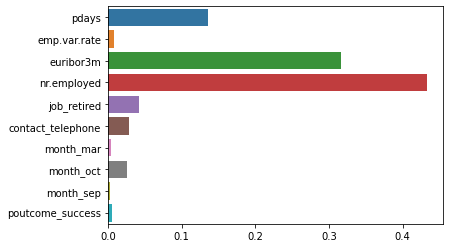

In [258]:
#Plotting feature importances
sns.barplot(dt_model.feature_importances_, X_train_transform_df[features_selected].columns);

In [66]:
#Checking accuracy scores
print(dt_model.score(X_train_transform_df[features_selected], y_train))
print(dt_model.score(X_val_transform_df[features_selected], y_val))

0.9179750728391065
0.8963340616654528


In [67]:
y_train_pred_dt = dt_model.predict(X_train_transform_df[features_selected])
y_val_pred_dt = dt_model.predict(X_val_transform_df[features_selected])

In [68]:
print(precision_score(y_train, y_train_pred_dt))
print(precision_score(y_val, y_val_pred_dt))

0.8359788359788359
0.5778894472361809


In [69]:
print(roc_auc_score(y_train, y_train_pred_dt))
print(roc_auc_score(y_val, y_val_pred_dt))

0.6657112681634325
0.6140735761937762


In [70]:
#Creating and fitting the model (balanced)
dt_model2 = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_model2.fit(X_train_transform_df[features_selected], y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [71]:
dt_model2.feature_importances_

array([0.03275004, 0.00312663, 0.31288964, 0.55838322, 0.0245622 ,
       0.03227053, 0.00121884, 0.02730758, 0.00150157, 0.00598975])

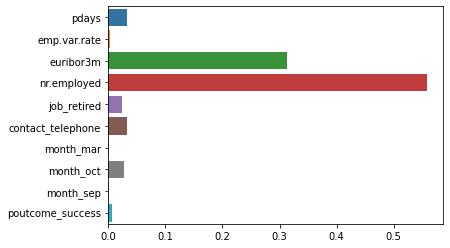

In [72]:
#Plotting feature importances
sns.barplot(dt_model2.feature_importances_, X_train_transform_df[features_selected].columns);

In [73]:
#Checking accuracy scores
print(dt_model2.score(X_train_transform_df[features_selected], y_train))
print(dt_model2.score(X_val_transform_df[features_selected], y_val))

0.8689705406280349
0.8497208060208788


In [75]:
y_train_pred_dt2 = dt_model2.predict(X_train_transform_df[features_selected])
y_val_pred_dt2 = dt_model2.predict(X_val_transform_df[features_selected])

In [76]:
#Checking precision scores
print(precision_score(y_train, y_train_pred_dt2))
print(precision_score(y_val, y_val_pred_dt2))

0.4438890277430642
0.3798507462686567


In [77]:
#Checking roc_auc scores
print(roc_auc_score(y_train, y_train_pred_dt2))
print(roc_auc_score(y_val, y_val_pred_dt2))

0.7676478974039439
0.7210916374531978


### Random Forest

In [78]:
#Creating model (Original)
rf_model = RandomForestClassifier(verbose=1, random_state=42)

In [79]:
#Fitting the model
rf_model.fit(X_train_transform_df[features_selected], y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)

In [80]:
#Using list indexing to access information in each of these individual decision trees
rf_model.estimators_[0].feature_importances_.round(3)

array([0.055, 0.353, 0.413, 0.006, 0.02 , 0.036, 0.004, 0.033, 0.004,
       0.076])

In [81]:
#Feature importance of random forest
rf_model.feature_importances_.round(3)

array([0.132, 0.059, 0.459, 0.181, 0.022, 0.03 , 0.02 , 0.02 , 0.003,
       0.073])

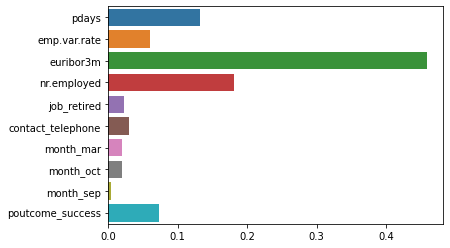

In [82]:
#Plotting feature importances
sns.barplot(rf_model.feature_importances_, X_train_transform_df[features_selected].columns);

In [83]:
#Checking accuracy scores
print(rf_model.score(X_train_transform_df[features_selected], y_train))
print(rf_model.score(X_val_transform_df[features_selected], y_val))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.9179346066688249
0.8963340616654528


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


In [84]:
y_train_pred_rf = rf_model.predict(X_train_transform_df[features_selected])
y_val_pred_rf = rf_model.predict(X_val_transform_df[features_selected])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished


In [85]:
#Checking precision soores
print(precision_score(y_train, y_train_pred_rf))
print(precision_score(y_val, y_val_pred_rf))

0.7984313725490196
0.5698198198198198


In [86]:
#Checking roc_auc scores
print(roc_auc_score(y_train, y_train_pred_rf))
print(roc_auc_score(y_val, y_val_pred_rf))

0.6766412650607188
0.6250575522234243


In [87]:
#Creating model (Balanced)
rf_model2 = RandomForestClassifier(verbose=1, random_state=42, class_weight='balanced')

In [88]:
#Fitting the model
rf_model2.fit(X_train_transform_df[features_selected], y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)

In [89]:
#Using list indexing to access information in each of these individual decision trees
rf_model2.estimators_[0].feature_importances_.round(3)

array([0.028, 0.526, 0.354, 0.007, 0.017, 0.027, 0.014, 0.015, 0.002,
       0.01 ])

In [90]:
#Feature importance of random forest
rf_model2.feature_importances_.round(3)

array([0.069, 0.146, 0.422, 0.247, 0.016, 0.031, 0.015, 0.021, 0.001,
       0.034])

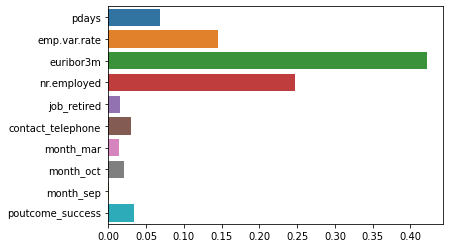

In [91]:
#Plotting feature importances
sns.barplot(rf_model2.feature_importances_, X_train_transform_df[features_selected].columns)

In [92]:
#Checking accuracy scores
print(rf_model2.score(X_train_transform_df[features_selected], y_train))
print(rf_model2.score(X_val_transform_df[features_selected], y_val))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.8830123017157656
0.8640446710366594


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished


In [93]:
y_train_pred_rf2 = rf_model2.predict(X_train_transform_df[features_selected])
y_val_pred_rf2 = rf_model2.predict(X_val_transform_df[features_selected])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished


In [94]:
#Checking precision_scores
print(precision_score(y_train, y_train_pred_rf2))
print(precision_score(y_val, y_val_pred_rf2))

0.4855195911413969
0.4126712328767123


In [95]:
#Checking roc_auc scores
print(roc_auc_score(y_train, y_train_pred_rf2))
print(roc_auc_score(y_val, y_val_pred_rf2))

0.7652350307794415
0.7162553123982398


## Boosting Models

### GradientBoosting

In [294]:
gb_model = GradientBoostingClassifier(verbose=2, random_state=42)

In [295]:
gb_model.fit(X_train_transform_df[features_selected], y_train)

      Iter       Train Loss   Remaining Time 
         1           0.7334            6.95s
         2           0.7075            7.76s
         3           0.6891            7.94s
         4           0.6730            8.06s
         5           0.6604            7.91s
         6           0.6510            7.78s
         7           0.6424            7.92s
         8           0.6362            7.61s
         9           0.6302            7.44s
        10           0.6261            7.42s
        11           0.6218            7.33s
        12           0.6186            7.02s
        13           0.6155            6.85s
        14           0.6132            6.82s
        15           0.6109            6.57s
        16           0.6095            6.58s
        17           0.6081            6.49s
        18           0.6064            6.37s
        19           0.6050            6.13s
        20           0.6038            5.99s
        21           0.6027            5.97s
        2

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=2,
                           warm_start=False)

In [296]:
gb_model.feature_importances_

array([0.10283393, 0.00221621, 0.15398399, 0.59886306, 0.00756333,
       0.0294489 , 0.02652139, 0.03553928, 0.00226981, 0.04076009])

Text(0, 0.5, 'Feature Importance')

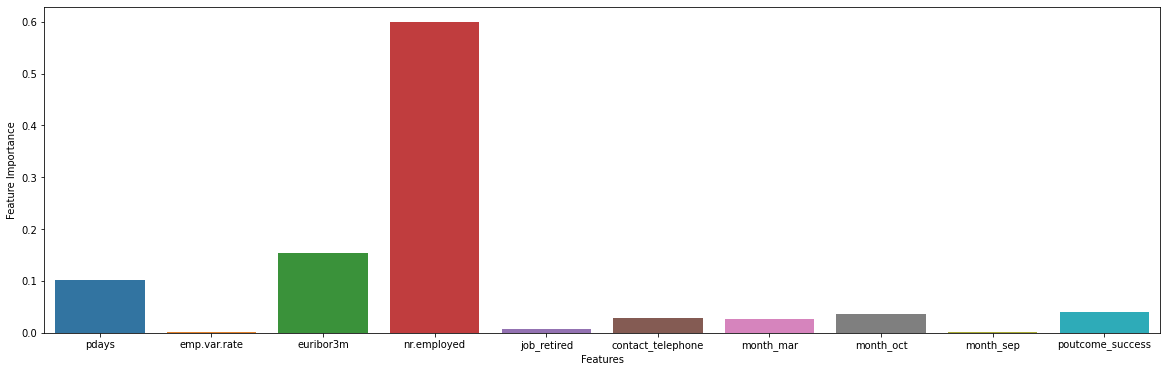

In [297]:
plt.figure(figsize=(20,6))
sns.barplot(features_selected, gb_model.feature_importances_)

plt.xlabel('Features')
plt.ylabel('Feature Importance')

In [298]:
gb_model.train_score_

array([0.73340968, 0.70749953, 0.68911988, 0.67303689, 0.66042855,
       0.6509993 , 0.64240769, 0.63619953, 0.6302096 , 0.62607246,
       0.62179583, 0.61857945, 0.61548184, 0.61315687, 0.61090035,
       0.60952063, 0.60805142, 0.60642006, 0.60495275, 0.6038239 ,
       0.60270877, 0.60098041, 0.600148  , 0.59950759, 0.59844022,
       0.5978869 , 0.59748807, 0.59649198, 0.59602248, 0.59555639,
       0.59486301, 0.59458139, 0.59409503, 0.59381642, 0.59355984,
       0.59329477, 0.59299725, 0.59263835, 0.59237281, 0.59215528,
       0.59197879, 0.59183195, 0.59163996, 0.59146988, 0.59137901,
       0.59113054, 0.5910445 , 0.59092599, 0.59070994, 0.59056389,
       0.59045854, 0.5903668 , 0.59019076, 0.59003598, 0.58991746,
       0.5897395 , 0.58960481, 0.5895353 , 0.58939545, 0.58922409,
       0.5891291 , 0.58903182, 0.5888927 , 0.58851325, 0.58839723,
       0.58836638, 0.58828802, 0.58805607, 0.58777273, 0.58769801,
       0.58763683, 0.58747127, 0.58727285, 0.58669839, 0.58661

In [299]:
#Checking recall scores
y_train_pred_gb = gb_model.predict(X_train_transform_df[features_selected])
y_val_pred_gb = gb_model.predict(X_val_transform_df[features_selected])

In [301]:
#Checking roc_auc score
print(roc_auc_score(y_train, y_train_pred_gb))
print(roc_auc_score(y_val, y_val_pred_gb))

0.6200407363044657
0.6109088356162112


### XGBoost

In [96]:
#Creating the model
xgb_model = XGBClassifier(max_depth = 6, 
                          learning_rate = 0.3,
                          n_estimators = 100,
                          booster = 'gbtree',
                          scale_pos_weight = 1,
                          colsample_bytree = 1,
                          subsample = 1,
                          min_child_weight = 0,
                          random_state = 42)

In [97]:
xgb_model.fit(X_train_transform_df[features_selected], y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=0, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [98]:
xgb_model.feature_importances_

array([0.01350075, 0.01243219, 0.01927681, 0.77970695, 0.00789488,
       0.01266058, 0.0206126 , 0.06391174, 0.01273663, 0.05726692],
      dtype=float32)

Text(0, 0.5, 'Feature Importance')

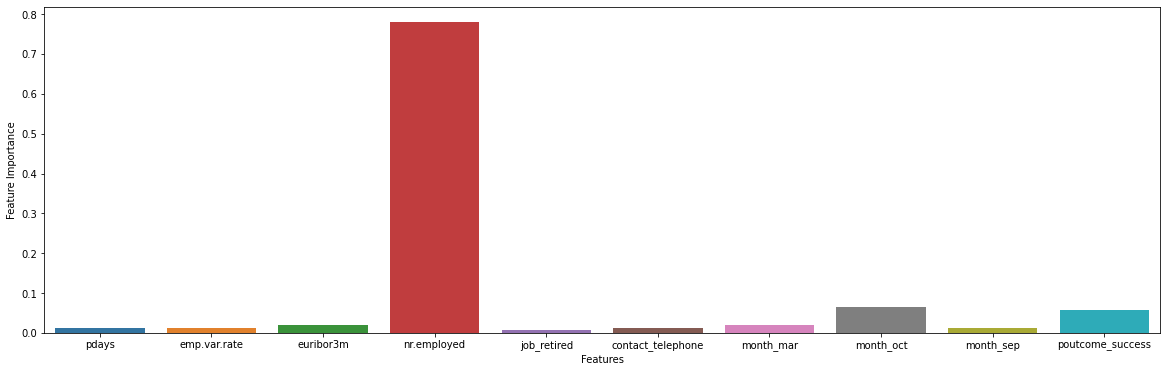

In [99]:
plt.figure(figsize=(20,6))
sns.barplot(features_selected, xgb_model.feature_importances_, dodge=False)

plt.xlabel('Features')
plt.ylabel('Feature Importance')

In [100]:
#Checking accuracy scores
print(xgb_model.score(X_train_transform_df[features_selected], y_train))
print(xgb_model.score(X_val_transform_df[features_selected], y_val))

0.9141712528326319
0.8990046127700898


In [101]:
y_train_pred_xg = xgb_model.predict(X_train_transform_df[features_selected])
y_val_pred_xg = xgb_model.predict(X_val_transform_df[features_selected])

In [102]:
#Checking precision scores
print(precision_score(y_train, y_train_pred_xg))
print(precision_score(y_val, y_val_pred_xg))

0.7724306688417618
0.5985915492957746


In [103]:
#Checking roc_auc scores
print(roc_auc_score(y_train, y_train_pred_xg))
print(roc_auc_score(y_val, y_val_pred_xg))

0.6634109323634709
0.6275150023438367


In [314]:
y_train.value_counts()

0    16593
1     2496
Name: target, dtype: int64

## Using Imbalanced-learn to Balance Dataset

### Logistic Regression

In [37]:
!pip install imbalanced-learn

In [38]:
from imblearn.under_sampling import RandomUnderSampler

In [39]:
#Set the sampler
rus = RandomUnderSampler(random_state=42)

In [40]:
#Fit the sampler
rus.fit(X_train_transform_df[features_selected], y_train)

RandomUnderSampler(random_state=42, replacement=False, sampling_strategy='auto')

In [113]:
#Fit and resample the data points
X_train_undersample, y_train_undersample = rus.fit_sample(X_train_transform_df[features_selected], y_train)
X_val_undersample, y_val_undersample = rus.fit_sample(X_val_transform_df[features_selected], y_val)

In [152]:
np.bincount(y_train_undersample)

array([2496, 2496])

In [160]:
np.bincount(y_val_undersample)

array([815, 815])

In [42]:
#Scaling with resampled data
rus_scaler = StandardScaler()
rus_scaler.fit(X_train_undersample)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [116]:
X_train_rus_scale = rus_scaler.transform(X_train_undersample)
X_val_rus_scale = rus_scaler.transform(X_val_undersample)

In [117]:
#Fit model with resampled data
rus_log_model = LogisticRegression(random_state=42)
rus_log_model.fit(X_train_rus_scale, y_train_undersample)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [118]:
y_train_rus_pred = rus_log_model.predict(X_train_rus_scale)
y_val_rus_pred = rus_log_model.predict(X_val_rus_scale)

In [119]:
#Checking accuracy scores
print(rus_log_model.score(X_train_rus_scale, y_train_undersample))
print(rus_log_model.score(X_val_rus_scale, y_val_undersample))

0.719612764431696
0.7177947598253275


In [121]:
#Checking precision socres
print(precision_score(y_train_undersample, y_train_rus_pred))
print(precision_score(y_val_undersample, y_val_rus_pred))

0.729314863347061
0.7189901207464325


In [120]:
#Checking roc_auc scores
print(roc_auc_score(y_train_undersample, y_train_rus_pred))
print(roc_auc_score(y_val_undersample, y_val_rus_pred))

0.7196127644316959
0.7177947598253275


### XGBoost

In [104]:
#Changing some parameters
xgb_model2 = XGBClassifier(max_depth = 10, 
                          learning_rate = 0.3,
                          n_estimators = 100,
                          booster = 'gbtree',
                          scale_pos_weight = 1,
                          colsample_bytree = 1,
                          subsample = 0.5,
                          min_child_weight = 0, 
                          tree_method = 'hist',
                          random_state = 42)

In [105]:
xgb_model2.fit(X_train_undersample, y_train_undersample)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.3, max_delta_step=0, max_depth=10,
              min_child_weight=0, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='hist', validate_parameters=False, verbosity=None)

In [106]:
xgb_model2.feature_importances_

array([0.0232567 , 0.10747942, 0.04936176, 0.5077325 , 0.0257787 ,
       0.03379563, 0.05561649, 0.07206564, 0.06285076, 0.06206243],
      dtype=float32)

Text(0, 0.5, 'Feature Importance')

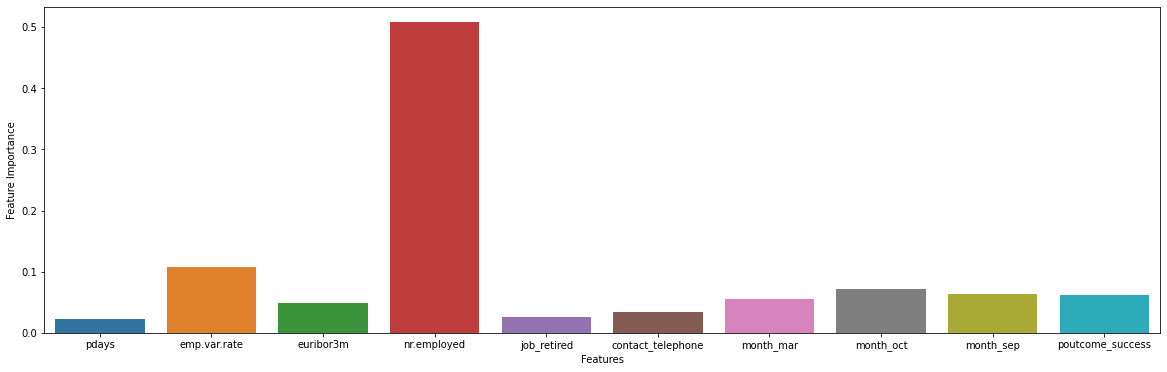

In [107]:
plt.figure(figsize=(20,6))
sns.barplot(features_selected, xgb_model2.feature_importances_)

plt.xlabel('Features')
plt.ylabel('Feature Importance')

In [108]:
y_train_pred_xg2 = xgb_model2.predict(X_train_undersample)
y_val_pred_xg2 = xgb_model2.predict(X_val_undersample)

In [109]:
#Checking accuracy scores
print(xgb_model2.score(X_train_undersample, y_train_undersample))
print(xgb_model2.score(X_val_undersample, y_val_undersample))

0.7681964861957691
0.730349344978166


In [110]:
#Checking precision socres
print(precision_score(y_train_undersample, y_train_pred_xg2))
print(precision_score(y_val_undersample, y_val_pred_xg2))

0.8428047662694775
0.7813333333333333


In [111]:
#Checking roc_auc scores
print(roc_auc_score(y_train_undersample, y_train_pred_xg2))
print(roc_auc_score(y_val_undersample, y_val_pred_xg2))

0.7681964861957691
0.730349344978166
